In [149]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

## Node Values

In [150]:
class Node():
    def __init__(
        self,
        feature_index=None,
        threshold=None,
        left=None,
        right=None,
        info_gain=None,
        value=None,
        normalized_cr = None):
        '''Constructor for the DT Nodes'''
        
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.normalized_correlation = normalized_cr
        
        # for leaf node
        self.value = value

## Decision Tree

In [151]:
class DecisionTreeClassifier():
    def __init__(
        self,
        min_samples_split=2,
        max_depth=2,
        normalized_correlation_values=None,
        information_gain_mode="entropy"):
        self.root = None
        
        #Base Case
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.normalized_correlation_values = normalized_correlation_values
        self.information_gain_mode = information_gain_mode
        
    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # print("Number of samples:", num_samples, "Number of features:", num_features)
        
        if num_samples >=  self.min_samples_split and curr_depth <= self.max_depth:
            
            # Find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            
            if best_split["info_gain"] > 0:
                # Recurrence in the left SubTree
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth + 1)
                
                # Recurrence in right subtree
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth + 1)
                
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
            
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        
        best_split = {}
        max_info_gain = -float("inf")
        # print("Dataset shape:", dataset.shape)
        for feature_index in range(num_features):
            # print(feature_index)
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            
            # Loop over all feature values in the dat
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    Y, Y_left, Y_right = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    
                    # Compute Information Gain using X's and Y's
                    if self.information_gain_mode == "entropy_af":
                        curr_info_gain = self.information_gain_af(Y, Y_left, Y_right, feature_index)
                    elif self.information_gain_mode == "entropy_chi":
                        chi_square_left_node = self.information_gain_chi_squared(Y, Y_left)
                        chi_square_right_node = self.information_gain_chi_squared(Y, Y_right)
                        
                        curr_info_gain = chi_square_left_node if chi_square_left_node > chi_square_right_node else chi_square_right_node
                    elif self.information_gain_mode == "entropy_gini_index":
                        curr_info_gain = self.information_gain_gini(Y, Y_left, Y_right)
                    else:
                        curr_info_gain = self.information_gain(Y, Y_left, Y_right)
                    
                    # print("Current Info Gain", curr_info_gain)
                    
                    # Update the best split if needed
                    if curr_info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        # print("Feature Index:", feature_index, "Threshold:", threshold)
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        
        # print("Y:", Y_left.shape, Y_right.shape)
        return dataset_left, dataset_right
    
    def information_gain_af(self, parent, l_child, r_child, f_index):
        p_l = len(l_child) / len(parent)
        p_r = len(r_child) / len(parent)
        
        return self.entropy(parent) - p_l * self.entropy(l_child) * self.normalized_correlation_values[f_index] - p_r * self.entropy(r_child) * self.normalized_correlation_values[f_index]
    
    def information_gain(self, parent, l_child, r_child):
        p_l = len(l_child) / len(parent)
        p_r = len(r_child) / len(parent)

        return self.entropy(parent) - p_l * self.entropy(l_child) - p_r * self.entropy(r_child)
    
    def information_gain_gini(self, parent, l_child, r_child):
        p_l = len(l_child) / len(parent)
        p_r = len(r_child) / len(parent)

        return self.entropy(parent) - p_l * self.gini_index(l_child) - p_r * self.gini_index(r_child)
    
    def information_gain_chi_squared(self, parent, child):
        unique_parent, counts_parent = np.unique(parent, return_counts=True)
        total_parent = np.sum(counts_parent)
        
        expected = np.mean([c / total_parent for c in counts_parent])
        # print("Expected: ", expected)
        
        unique_child, counts_child = np.unique(child, return_counts=True)
        total_child = sum(counts_child)
        
        actual = np.mean([c / total_child for c in counts_child])
        
        # print("Actual: ", actual)
        
        return np.sqrt((expected - actual) ** 2 / expected)
        
        
        
    def entropy(self, Y):
        class_labels = np.unique(Y)
        entropy = 0
        
        for cls in class_labels:
            p_cls = len(Y[Y == cls]) / len(Y)
            entropy += -p_cls * np.log2(p_cls)
            
        return entropy
    
    def gini_index(self, Y):
        ''' Computes the gini-index '''
        
        class_labels = np.unique(Y)
        gini_value = 0
        
        for cls in class_labels:
            p_cls = len(Y[Y == cls]) / len(Y)
            gini_value += np.power(p_cls, 2)
        
        return 1 - gini_value
    
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf nodes  '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        
        if not tree:
            tree = self.root
            
        if tree.value is not None:
            print(tree.value)
            
        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
            
    def predict(self, X):
        ''' function to predict new dataset '''
        predictions = []
        
        for x in X:
            # print(x)
            predictions.append(
                self.make_prediction(x, self.root))
            
        return predictions
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        dataset = np.concatenate((X, Y), axis=1)
        
        self.root = self.build_tree(dataset)
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value != None:
            return tree.value
        # print(x)
        feature_val = x[tree.feature_index]
        
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [152]:
d = {'Age': [ "lt40", "lt30", "bw30-40", "gt40", "lt30", "gt40", "bw30-40", "lt30", "lt30", "gt40" ],
     'Color-cloth': ["Red", "Yellow", "Blue", "Red", "White", "Red", "Blue", "Yellow", "Yellow", "White"],
     'Income': [ 'High', 'High', 'High', 'Medium', 'Low', 'Low', 'Low', 'Medium', 'Low', 'Medium' ],
     'Student': ['No', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No'],
     'Buy-Computer': ['No', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'No']}

df = pd.DataFrame(data=d)
columns = df.columns
df

,Age,Color-cloth,Income,Student,Buy-Computer
0,lt40,Red,High,No,No
1,lt30,Yellow,High,No,No
2,bw30-40,Blue,High,No,Yes
3,gt40,Red,Medium,No,Yes
4,lt30,White,Low,Yes,No
5,gt40,Red,Low,Yes,No
6,bw30-40,Blue,Low,Yes,Yes
7,lt30,Yellow,Medium,No,Yes
8,lt30,Yellow,Low,Yes,No
9,gt40,White,Medium,No,No


In [153]:
X, y = df.values[:, :-1], df.values[:, -1]

Y = y.reshape(-1, 1)
Y.shape

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [154]:
X

array([['lt40', 'Red', 'High', 'No'],
       ['lt30', 'Yellow', 'High', 'No'],
       ['bw30-40', 'Blue', 'High', 'No'],
       ['gt40', 'Red', 'Medium', 'No'],
       ['lt30', 'White', 'Low', 'Yes'],
       ['gt40', 'Red', 'Low', 'Yes'],
       ['bw30-40', 'Blue', 'Low', 'Yes'],
       ['lt30', 'Yellow', 'Medium', 'No'],
       ['lt30', 'Yellow', 'Low', 'Yes'],
       ['gt40', 'White', 'Medium', 'No']], dtype=object)

In [155]:
Y

array([['No'],
       ['No'],
       ['Yes'],
       ['Yes'],
       ['No'],
       ['No'],
       ['Yes'],
       ['Yes'],
       ['No'],
       ['No']], dtype=object)

## Label Encoding

In [156]:
le = preprocessing.LabelEncoder()

df_encoded = df.copy()

df_encoded.columns

Index(['Age', 'Color-cloth', 'Income', 'Student', 'Buy-Computer'], dtype='object')

In [157]:
# Label Buying

df_encoded['Age'] = le.fit_transform(df['Age'])
df_encoded['Color-cloth'] = le.fit_transform(df['Color-cloth'])
df_encoded['Income'] = le.fit_transform(df['Income'])
df_encoded['Student'] = le.fit_transform(df['Student'])
df_encoded['Buy-Computer'] = le.fit_transform(df['Buy-Computer'])

df_encoded.head()

,Age,Color-cloth,Income,Student,Buy-Computer
0,3,1,0,0,0
1,2,3,0,0,0
2,0,0,0,0,1
3,1,1,2,0,1
4,2,2,1,1,0


In [158]:
def AF_algorithm(D_values):
    af_set = []
    C_values = D_values[:, -1]
    AF_values = D_values[:, :-1]
    
    print(AF_values.shape, C_values.shape)
    
    for i in range(0, AF_values.shape[1]):
        print("Unique values: ", np.unique(AF_values[:, i]))
        af_set.append(
            np.sum(
                np.abs(AF_values[:, i] - C_values), axis=0) / len(np.unique(AF_values[:, i])))
    
    return af_set

def calculate_normalized_AF(AF_values):
    AF_normalized = []
    
    for i in range(AF_values.shape[0]):
        AF_normalized.append(AF_values[i] / np.sum(AF_values, axis=0))
    
    return AF_normalized
    
AF_values = np.array(AF_algorithm(df_encoded.values))
print(AF_values.shape)
normalized_AF_values = calculate_normalized_AF(AF_values) 

print(normalized_AF_values)

(10, 4) (10,)
Unique values:  [0 1 2 3]
Unique values:  [0 1 2 3]
Unique values:  [0 1 2]
Unique values:  [0 1]
(4,)
[0.2658227848101266, 0.3037974683544304, 0.20253164556962025, 0.2278481012658228]


## Running Decision Tree on Normal Information Gain with Entropy function

In [159]:
classifier = DecisionTreeClassifier(
    min_samples_split=5,
    max_depth=5,
    information_gain_mode="entropy")

classifier.fit(X_train,Y_train)
classifier.print_tree()

X_0 <= bw30-40 ? 0.31127812445913283
 left:Yes
 right:X_2 <= Low ? 0.4591479170272448
  left:No
  right:Yes


In [160]:
Y_pred = classifier.predict(X)

In [161]:
accuracy_score(Y, Y_pred)

0.9

## Running Decision Tree on Normal Information Gain with Entropy function with Correlation Function

In [162]:
classifier_af = DecisionTreeClassifier(
    min_samples_split=5,
    max_depth=5,
    normalized_correlation_values=normalized_AF_values,
    information_gain_mode="entropy_af")

classifier_af.fit(X_train,Y_train)
classifier_af.print_tree()

X_0 <= bw30-40 ? 0.8169220330840733
 left:Yes
 right:X_2 <= Low ? 0.8253038508590982
  left:No
  right:Yes


In [163]:
Y_pred = classifier_af.predict(X)
accuracy_score(Y, Y_pred)

0.9

## Running Decision Tree on Normal Information Gain with Chi-squared function

In [164]:
classifier_chi2 = DecisionTreeClassifier(
    min_samples_split=5,
    max_depth=5,
    information_gain_mode="entropy_chi")

classifier_chi2.fit(X_train,Y_train)
classifier_chi2.print_tree()

X_0 <= bw30-40 ? 0.7071067811865476
 left:Yes
 right:X_0 <= lt30 ? 0.7071067811865476
  left:X_1 <= White ? 0.7071067811865476
    left:No
    right:Yes
  right:No


In [165]:
Y_pred = classifier_chi2.predict(X)

In [166]:
accuracy_score(Y, Y_pred)

0.7

## Running Decision Tree on Normal Information Gain with Gini-Index

In [167]:
classifier_gini = DecisionTreeClassifier(
    min_samples_split=5,
    max_depth=5,
    information_gain_mode="entropy_gini_index")

classifier_gini.fit(X_train,Y_train)
classifier_gini.print_tree()

X_0 <= bw30-40 ? 0.6666666666666667
 left:Yes
 right:X_2 <= Low ? 0.6960736118322673
  left:No
  right:Yes


In [168]:
Y_pred = classifier_gini.predict(X)
accuracy_score(Y, Y_pred)

0.9

## Using Scikit Learn 

In [169]:
from sklearn import tree

In [170]:
X = df_encoded.drop(columns=["Buy-Computer"])
X.head()

X = X.values

In [171]:
Y = df_encoded["Buy-Computer"]
Y = Y.values.reshape(-1, 1)
Y.shape

(10, 1)

In [172]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("X_train shape : ", X_train.shape)
print("Y_train shape : ", Y_train.shape)
print("X_test shape : ", X_test.shape)
print("Y_test shape : ", Y_test.shape)

X_train shape :  (8, 4)
Y_train shape :  (8, 1)
X_test shape :  (2, 4)
Y_test shape :  (2, 1)


In [173]:
clf = tree.DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(X_train, Y_train)

In [174]:
Y_pred = clf.predict(X)
accuracy_score(Y, Y_pred)

1.0

Attribute: Index(['Age', 'Color-cloth', 'Income', 'Student'], dtype='object')
Class values: ['No' 'Yes']


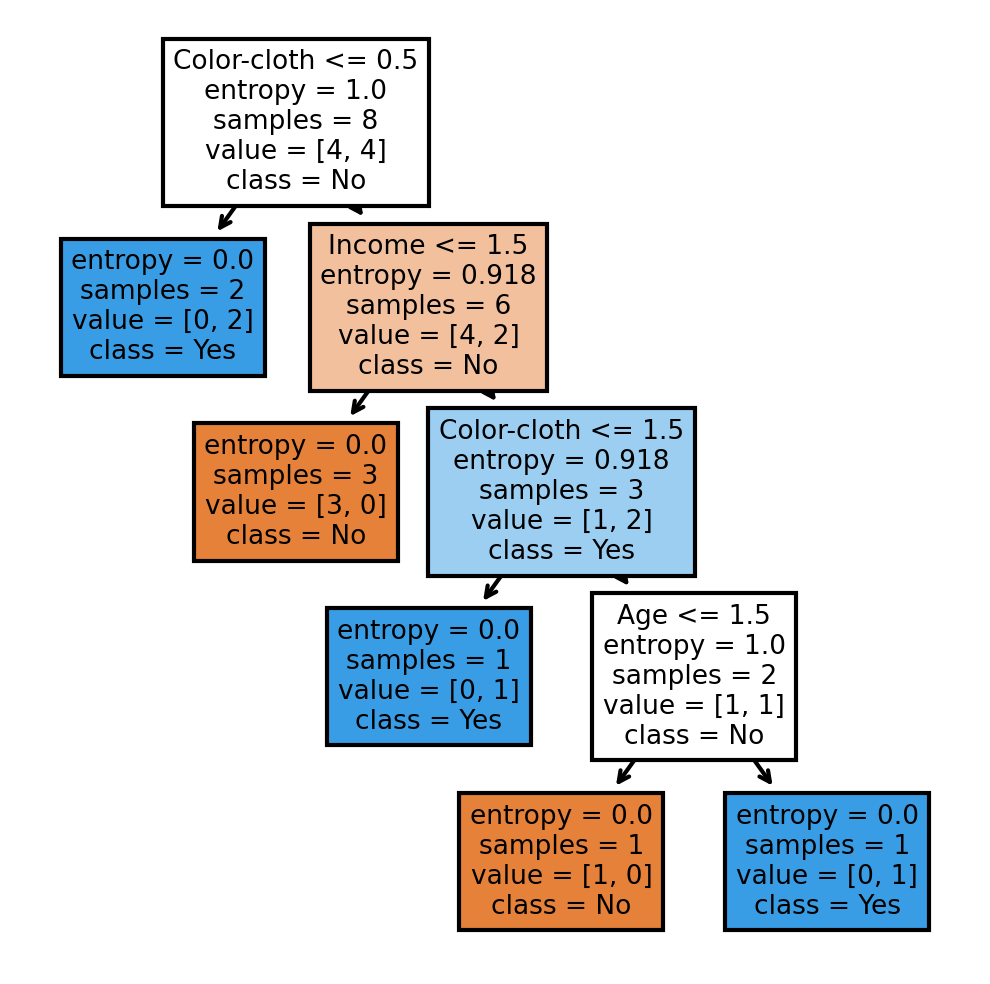

In [176]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)

attr_columns = columns[:-1]
class_values = np.unique(df["Buy-Computer"].values)

print("Attribute:", attr_columns)
print("Class values:", class_values)

tree.plot_tree(clf,
           feature_names = attr_columns.values, 
           class_names=class_values,
           filled = True)
fig.savefig('Custom_Dataset_Tree.png')